In [12]:
# Импорт необходимых библиотек
from selenium import webdriver
from selenium.webdriver.support.ui import Select
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager
import pandas as pd
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim, Photon, MapBox
from shapely.geometry import Point
import geopandas as gpd

In [15]:
# Функция для получения данных за определенную дату
def get_data(day, month, year):
    # Выбор элементов "select" (дата)
    day_select = Select(driver.find_element(By.ID, 'day'))
    month_select = Select(driver.find_element(By.ID, 'month'))
    year_select = Select(driver.find_element(By.ID, 'year'))

    day_select.select_by_value(str(day))
    month_select.select_by_value(str(month))
    year_select.select_by_value(str(year))

    time.sleep(2)

    # Парсинг таблицы с данными
    # table = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.TAG_NAME, 'table')))
    table = driver.find_element(By.TAG_NAME, 'table')
    rows = table.find_elements(By.TAG_NAME, 'tr')[2:]  # Пропуск лишних заголовков

    data_rows = []
    
    for row in rows:
        cols = row.find_elements(By.TAG_NAME, 'td')
        if len(cols) < 4:
            continue
        
        # Считывание столбцов таблицы
        record_id = cols[0].text.strip()
        address = cols[1].text.strip()
        pm10_str = cols[2].text.strip()
        pm2_5_str = cols[3].text.strip()
        
        # Адаптация числовых данных под формат с разделительной точкой "."
        pm10_str = pm10_str.replace(',', '.')
        pm2_5_str = pm2_5_str.replace(',', '.')

        address = address.replace('СПб', 'Санкт-Петербург') # Необходимо для успешного геокодирования

        # Обработка значений PM10
        # Учёт особых значений PM10 и PM2.5
        if pm10_str == '' or pm10_str == '-*':
            pm10_value = None
        elif pm10_str == 'менее 0,1':
            pm10_value = 0.1
        else:
            try:
                pm10_value = float(pm10_str)  # Преобразование в float
            except ValueError:
                pm10_value = None  # Если преобразование не удалось

        # Обработка значений PM2.5
        if pm2_5_str == '' or pm2_5_str == '-*':
            pm2_5_value = None
        elif pm2_5_str == 'менее 0,1':
            pm2_5_value = 0.1
        else:
            try:
                pm2_5_value = float(pm2_5_str)  # Преобразование в float
            except ValueError:
                pm2_5_value = None  # Если преобразование не удалось

        # Комплектация итогового словаря с результатами обработки парсинга
        data_rows.append({
            'id': record_id,
            'date': f"{day}.{month}.{year}",
            'address': address,
            'pm10': pm10_value,
            'pm2_5': pm2_5_value
        })

    return data_rows

In [16]:
# Получение данных за несколько дней
start_date = pd.to_datetime("2024-09-01")
end_date = pd.to_datetime("2024-10-04") 
all_data = []

# Настройка Selenium WebDriver
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))

#

# URL страницы
url = "https://public.mon.ecopass.adc.spb.ru/air/particle" 
driver.get(url)

for single_date in pd.date_range(start_date, end_date):
    day = single_date.day
    month = single_date.month - 1 # На сайте осуществляется нумерация месяцев с 0
    year = single_date.year
    
    data = get_data(day, month, year)
    all_data.extend(data)  # Добавление данных в общий список

# Создание DataFrame из собранных данных
df = pd.DataFrame(all_data)

df

In [151]:
df.head(20)

,id,date,address,pm10,pm2_5
0,1,1.8.2024,"Санкт-Петербург, ул.Профессора Попова, д. 48",0.2,0.2
1,3,1.8.2024,"Санкт-Петербург, ул. Карбышева, д. 7",0.2,0.2
2,4,1.8.2024,"Санкт-Петербург, ул. Жака Дюкло, д.66",NaN,NaN
3,5,1.8.2024,"Санкт-Петербург, ЦПКиО им. С.М. Кирова, Елагин...",0.2,0.2
4,7,1.8.2024,"Санкт-Петербург, ул. Кирочная, д.41",NaN,NaN
5,8,1.8.2024,"Санкт-Петербург, Новосельковская ул., д. 23",0.2,0.2
6,9,1.8.2024,"Санкт-Петербург, Малая Балканская ул., д.54",0.2,0.3
7,11,1.8.2024,"г. Зеленогорск, Приморское шоссе, д.570",NaN,0.2
8,13,1.8.2024,"Санкт-Петербург, пр. Индустриальный, д. 64",0.1,NaN
9,14,1.8.2024,"Санкт-Петербург, Уткин проспект, д.16",NaN,NaN


In [158]:
# Геокодирование полученных адресов

# В связи с тем, что станции мониторинга всегда одинаковы и кодируются уникальным идентификатором в поле id,
# осуществим геокодирование для одного (полного) набора адресов

geolocator = Photon(user_agent="MyApp/1.0")
location_cache = {} # Словарь для записи возможных геокодированных координат 

def geocode_address(address):
    try:
        # Дополнительная обработка адреса для обработки исключений (Кронштадт, Пушкин и Ломоносов)
        if address[:2] == 'г.': # Проверка на исключение
            address = [list(address.split(','))[::-1][0][-1]] + list(address.split(','))[::-1][1:] # "Переворачивание" адреса

            address_fin = ''
            for i in address:
                address_fin += i + ' ' # Дополнение пробелами
                address = address_fin + 'Санкт-Петербург' # Дополнение адреса уточнением ГФЗ

        location = geolocator.geocode(address, timeout=10) # В случае с плохим интернет-соединением, возможно увеличить величину timeout
        print(f'{address} ГЕОКОДИРОВАН')

        return location.latitude, location.longitude
    except:
        print(f"Ошибка геокодирования для адреса '{address}'")
    
    return None, None

# Обработка первых 20 id
for id in df['id'].head(20):
    # Фильтруем DataFrame по id
    filtered_df = df[df['id'] == id]
    
    # Проверяем, есть ли строки в отфильтрованном DataFrame
    if not filtered_df.empty:
        address = filtered_df.iloc[0]['address']  # Используем iloc для доступа к первому элементу
        print(id, address)
        location_cache[id] = geocode_address(address)
    else:
        print(f"Адрес для id {id} не найден.")

location_cache

1 Санкт-Петербург, ул.Профессора Попова, д. 48
Санкт-Петербург, ул.Профессора Попова, д. 48 ГЕОКОДИРОВАН
3 Санкт-Петербург, ул. Карбышева, д. 7
Санкт-Петербург, ул. Карбышева, д. 7 ГЕОКОДИРОВАН
4 Санкт-Петербург, ул. Жака Дюкло, д.66
Санкт-Петербург, ул. Жака Дюкло, д.66 ГЕОКОДИРОВАН
5 Санкт-Петербург, ЦПКиО им. С.М. Кирова, Елагин остров, д.4
Санкт-Петербург, ЦПКиО им. С.М. Кирова, Елагин остров, д.4 ГЕОКОДИРОВАН
7 Санкт-Петербург, ул. Кирочная, д.41
Санкт-Петербург, ул. Кирочная, д.41 ГЕОКОДИРОВАН
8 Санкт-Петербург, Новосельковская ул., д. 23
Санкт-Петербург, Новосельковская ул., д. 23 ГЕОКОДИРОВАН
9 Санкт-Петербург, Малая Балканская ул., д.54
Санкт-Петербург, Малая Балканская ул., д.54 ГЕОКОДИРОВАН
11 г. Зеленогорск, Приморское шоссе, д.570
0  Приморское шоссе г. Зеленогорск Санкт-Петербург ГЕОКОДИРОВАН
13 Санкт-Петербург, пр. Индустриальный, д. 64
Санкт-Петербург, пр. Индустриальный, д. 64 ГЕОКОДИРОВАН
14 Санкт-Петербург, Уткин проспект, д.16
Санкт-Петербург, Уткин проспект, д.16 Г

{'1': (59.9690491, 30.2847266790493),
 '3': (59.9416668, 30.29922753294),
 '4': (60.0231254, 30.3376829),
 '5': (59.9804303, 30.2639221),
 '7': (59.94220455, 30.371373053831075),
 '8': (59.9306741, 30.4404379),
 '9': (59.9357623, 30.3133345),
 '11': (60.1921345, 29.7033446),
 '13': (59.9306741, 30.4404379),
 '14': (59.9347001, 30.4225445),
 '15': (59.9864681, 29.7900676),
 '16': (59.876524, 30.2441422),
 '17': (59.6988399, 30.3749957),
 '18': (60.04251975, 30.394182199999996),
 '19': (59.83872925, 30.116597697729038),
 '20': (59.9306741, 30.4404379),
 '21': (59.93438235, 30.328749280700762),
 '22': (59.9046635, 30.2176111),
 '24': (59.93714065, 30.263480800000004),
 '25': (59.80794695, 30.567922989829718)}

In [165]:
# Создание дополнительного DataFrame для средних значений (за весь период) PM10 и PM2.5 по каждому адресу
average_df = df.groupby('id').agg({'address': 'first', 'pm10': 'mean', 'pm2_5': 'mean'}).reset_index()
average_df

,id,address,pm10,pm2_5
0,1,"Санкт-Петербург, ул.Профессора Попова, д. 48",0.542424,0.358824
1,11,"г. Зеленогорск, Приморское шоссе, д.570",NaN,0.244444
2,13,"Санкт-Петербург, пр. Индустриальный, д. 64",0.223333,NaN
3,14,"Санкт-Петербург, Уткин проспект, д.16",0.556000,0.412000
4,15,"г. Кронштадт, ул. Ильмянинова, д.4",NaN,NaN
5,16,"Санкт-Петербург, Московский пр., дом 139, к. 2...",NaN,0.225000
6,17,"г. Пушкин, Тиньков пер., д.4",0.500000,0.397059
7,18,"Санкт-Петербург, ул. Ольги Форш, д.6",NaN,NaN
8,19,"Санкт-Петербург, пр. Ветеранов, д.167, к. 6, с...",0.527273,0.436364
9,20,"Санкт-Петербург, ул. Тельмана, д.24",0.266667,NaN


In [166]:
# Добавление координат из location_cache в average_df по id
average_df['latitude'] = average_df['id'].map(lambda addr: next((location_cache[id][0] for id in location_cache if df[df['id'] == id]['id'].iloc[0] == addr), None))
average_df['longitude'] = average_df['id'].map(lambda addr: next((location_cache[id][1] for id in location_cache if df[df['id'] == id]['id'].iloc[0] == addr), None))
average_df

,id,address,pm10,pm2_5,latitude,longitude
0,1,"Санкт-Петербург, ул.Профессора Попова, д. 48",0.542424,0.358824,59.969049,30.284727
1,11,"г. Зеленогорск, Приморское шоссе, д.570",NaN,0.244444,60.192135,29.703345
2,13,"Санкт-Петербург, пр. Индустриальный, д. 64",0.223333,NaN,59.930674,30.440438
3,14,"Санкт-Петербург, Уткин проспект, д.16",0.556000,0.412000,59.934700,30.422545
4,15,"г. Кронштадт, ул. Ильмянинова, д.4",NaN,NaN,59.986468,29.790068
5,16,"Санкт-Петербург, Московский пр., дом 139, к. 2...",NaN,0.225000,59.876524,30.244142
6,17,"г. Пушкин, Тиньков пер., д.4",0.500000,0.397059,59.698840,30.374996
7,18,"Санкт-Петербург, ул. Ольги Форш, д.6",NaN,NaN,60.042520,30.394182
8,19,"Санкт-Петербург, пр. Ветеранов, д.167, к. 6, с...",0.527273,0.436364,59.838729,30.116598
9,20,"Санкт-Петербург, ул. Тельмана, д.24",0.266667,NaN,59.930674,30.440438


In [167]:
# Создание GeoDataFrame
average_gdf = gpd.GeoDataFrame(average_df)

# Создание нового поля geometry из latitude и longitude
average_gdf['geometry'] = average_gdf.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

# Создание GeoDataFrame с указанием CRS
average_gdf = gpd.GeoDataFrame(average_df, geometry=average_gdf['geometry'], crs="EPSG:3857")

average_gdf.to_file("output_data.shp", driver='ESRI Shapefile') # Сохранение GeoDataFrame в формате SHP-файла

average_gdf

,id,address,pm10,pm2_5,latitude,longitude,geometry
0,1,"Санкт-Петербург, ул.Профессора Попова, д. 48",0.542424,0.358824,59.969049,30.284727,POINT (30.285 59.969)
1,11,"г. Зеленогорск, Приморское шоссе, д.570",NaN,0.244444,60.192135,29.703345,POINT (29.703 60.192)
2,13,"Санкт-Петербург, пр. Индустриальный, д. 64",0.223333,NaN,59.930674,30.440438,POINT (30.440 59.931)
3,14,"Санкт-Петербург, Уткин проспект, д.16",0.556000,0.412000,59.934700,30.422545,POINT (30.423 59.935)
4,15,"г. Кронштадт, ул. Ильмянинова, д.4",NaN,NaN,59.986468,29.790068,POINT (29.790 59.986)
5,16,"Санкт-Петербург, Московский пр., дом 139, к. 2...",NaN,0.225000,59.876524,30.244142,POINT (30.244 59.877)
6,17,"г. Пушкин, Тиньков пер., д.4",0.500000,0.397059,59.698840,30.374996,POINT (30.375 59.699)
7,18,"Санкт-Петербург, ул. Ольги Форш, д.6",NaN,NaN,60.042520,30.394182,POINT (30.394 60.043)
8,19,"Санкт-Петербург, пр. Ветеранов, д.167, к. 6, с...",0.527273,0.436364,59.838729,30.116598,POINT (30.117 59.839)
9,20,"Санкт-Петербург, ул. Тельмана, д.24",0.266667,NaN,59.930674,30.440438,POINT (30.440 59.931)


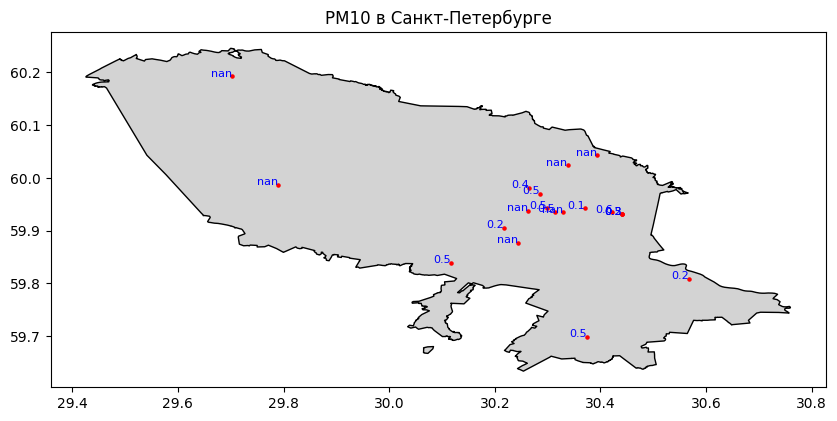

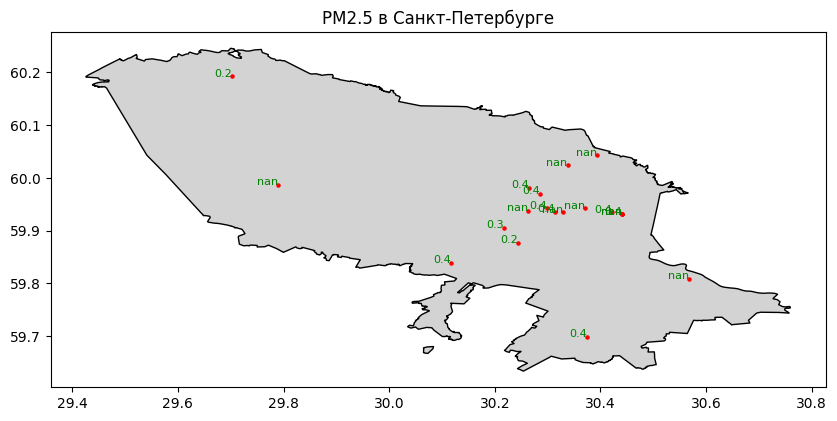

In [187]:
# Загрузка полигона Санкт-Петербурга (предполагается, что файл находится по указанному пути)
spb_polygon = gpd.read_file(r'C:\MSU\4_grade\addt\SPB.shp')  # Укажите локальный путь к файлу

# Построение графика для PM10
fig, ax = plt.subplots(figsize=(10, 10))
spb_polygon.plot(ax=ax, color='lightgrey', edgecolor='black')  # Плотим полигон
average_gdf.plot(ax=ax, marker='o', color='red', markersize=5)  # Плотим точки

# Добавление подписей значений PM10
for x, y, label in zip(average_gdf['longitude'], average_gdf['latitude'], average_gdf['pm10']):
    ax.text(x, y, f'{label:.1f}', fontsize=8, ha='right', color='blue')

plt.title('PM10 в Санкт-Петербурге')
plt.show()

# Построение графика для PM2.5
fig, ax = plt.subplots(figsize=(10, 10))
spb_polygon.plot(ax=ax, color='lightgrey', edgecolor='black')  # Плотим полигон
average_gdf.plot(ax=ax, marker='o', color='red', markersize=5)  # Плотим точки

# Добавление подписей значений PM2.5
for x, y, label in zip(average_gdf['longitude'], average_gdf['latitude'], average_gdf['pm2_5']):
    ax.text(x, y, f'{label:.1f}', fontsize=8, ha='right', color='green')

plt.title('PM2.5 в Санкт-Петербурге')
plt.show()